# Going deep into Human Activity Recognition

**Elia Bonetto, Filippo Rigotto.**

Department of Information Engineering, University of Padova, Italy.

Human Data Analytics, a.y. 2018/2019

## Part 4 - Results visualization

Here is the code for report's plots.

In [0]:
from IPython.display import Image, HTML, clear_output
import os
from google.colab import drive
drive.mount('/content/drive/')
clear_output()
os.chdir("/content/drive/My Drive/hda-project")
#!ls

In [0]:
from IPython.display import Image, HTML, clear_output
from pprint import pprint
import json
import os

import numpy as np
import scipy as sp
import scipy.io

import pandas as pd
pd.set_option('precision',3)
pd.set_option('display.precision',3)
pd.set_option('display.float_format', '{:0.3f}'.format)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (6,4)#(16,10)
mpl.rcParams['axes.grid'] = True
%matplotlib inline

## Utils

In [0]:
labels = [
    'RUNNING', 'WALKING', 'JUMPING','STNDING','SITTING', 'XLYINGX', 'FALLING',
    'WALKUPS', 'WALKDWS',
    'JUMPVRT', 'JUMPFWD', 'JUMPBCK', 
    'TRANSUP', 'TRANSDW', 'TRNSACC', 'TRNSDCC', 'TRANSIT'
]

# full map for all 17 classes
map_encode = { label:i for i,label in enumerate(labels) }

# map to squeeze down to 8 classes
map_encode_8 = {
    0:0,   1:1,  2:2,  3:3,  4:4,  5:5,  6:6, # untouched
    7:1,   8:1,                  # walking up and downstairs = walking
    9:2,  10:2, 11:2,            # jumping in place, forward and backward = jumping
    12:7, 13:7, 14:7, 15:7, 16:7 # all transitions
}

# useful for plots
map_decode_8 = {
    0: 'running',
    1: 'walking',
    2: 'jumping',
    3: 'standing',
    4: 'sitting',
    5: 'lying',
    6: 'falling',
    7: 'transition'
}

## Data reading

In [0]:
def get_folders(odir='output'):
    folders = []
    for d1 in [f for f in os.listdir(os.path.join(odir)) if os.path.isdir(os.path.join(odir, f))]:
        for d2 in os.listdir(os.path.join(odir,d1)):
            for d3 in os.listdir(os.path.join(odir,d1,d2)):
                #print(f"{d1} <> {d2} <> {d3}")
                folders.append(os.path.join(odir,d1,d2,d3))
    return folders

In [0]:
write_dir = 'report-misc'
output_dir = 'output'
folders = get_folders(output_dir)

In [0]:
print(f"Found {len(folders)} directories.")

container = {}
for i,folder in enumerate(folders):
    #print(f"Doing {folder.split('/')[-1]}")
    print('.',end='')
    if (i+1) % 40 == 0: print()

    path = folder # os.path.join(output_folder,folder)
    conf_file = os.path.join(path,'config.json')
    hist_file = os.path.join(path,'history.json')
    epoch_file = os.path.join(path,'epochs.json')
    eval_files = [ os.path.join(path, f) for f in os.listdir(path) if 'evaluation' in f ]
    eval_names = [ f.replace('evaluation-','').replace('.json','') for f in os.listdir(path) if 'evaluation' in f ]
    plot_files = [ os.path.join(path, f.replace('pdf','png')) for f in os.listdir(path) if 'plot' in f and 'pdf' in f ]
    plot_names = [ f.replace('plot-','').replace('.pdf','') for f in os.listdir(path) if 'plot' in f and 'png' in f ]

    with open(conf_file) as cf:
        conf = json.load(cf)
    with open(hist_file) as hf:
        hist = json.load(hf)
    with open(epoch_file) as ef:
        epochs = json.load(ef)
        
    evals = {}
    for i,ef in enumerate(eval_files):
        with open(ef) as ef2:
            evals[eval_names[i]] = json.load(ef2)
    
    plots = {}
    for i,pf in enumerate(plot_files):
        plots[plot_names[i]] = pf
    
    key = '_'.join(folder.split('/')[-1].split('_')[1:])
    container[key] = {
        'conf': conf,
        'hist': hist,
        'eval_epochs': epochs,
        'eval': evals, 
        'plots': plots
    }

clear_output()
ae_keys = [k for k in container.keys() if 'AE' in k]
container_ae = {k:container[k] for k in container if k in ae_keys}
container_single = {k:container[k] for k in container if k not in ae_keys}
del container

In [0]:
print(f"Single net runs: {len(container_single)}")
print(f"AE net runs:     {len(container_ae)}")

with open(f"{write_dir}/container_single.json",'w') as cf:
    json.dump(container_single, cf, indent=2)

with open(f"{write_dir}/container_ae.json",'w') as cf:
    json.dump(container_ae, cf, indent=2)

Single net runs: 60
AE net runs:     74


## Plots

Best accuracy and F1 for every run

In [0]:
best_evals = []
for test in container_single:
    ds, net = test.split('_')
    best_accu = 0
    best_accu_met = ''
    best_f1 = 0
    best_f1_met = ''
    for ev in container_single[test]['eval']:
        eval_dic = container_single[test]['eval'][ev]
        eval_epochs = container_single[test]['eval_epochs']
        try:
            epo = eval_epochs[ev.replace('best-','')]
        except:
            epo = '   '
        #print(f"{test} {ev} @ {epo}\t\t{eval_dic['acc']}\t {eval_dic['f1']}") # DEBUG here!
        if eval_dic['acc'] > best_accu and eval_dic['f1'] > best_f1:
            best_accu = eval_dic['acc']
            best_accu_met = ev.replace('best-','')
            best_f1 = eval_dic['f1']
            best_f1_met = ev.replace('best-','')
        elif eval_dic['acc'] > best_accu:
            best_accu = eval_dic['acc']
            best_accu_met = ev.replace('best-','')
        elif eval_dic['f1'] > best_f1:
            best_f1 = eval_dic['f1']
            best_f1_met = ev.replace('best-','')
    #print() # DEBUG here!
    best_evals.append([ds,net,best_accu*100,best_accu_met,best_f1*100,best_f1_met])

best_evals_2 = [[it[0],it[1],f"{it[2]:.3f} ({it[3]})   {it[4]:.3f} ({it[5]})"] for it in best_evals]
best_evals_3 = [[it[0],it[1],it[2],it[4]] for it in best_evals]
#dfVal = pd.DataFrame(best_evals_3, columns=['ds','net','acc','f1'])
#dfAcc = dfVal.pivot(index='ds', columns='net', values='acc')[['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
#dfF1s = dfVal.pivot(index='ds', columns='net', values='f1') [['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
#dfAccRev = dfVal.pivot(index='net', columns='ds', values='acc')
#dfF1sRev = dfVal.pivot(index='net', columns='ds', values='f1')

In [0]:
df = pd.DataFrame(best_evals_2, columns=['ds','net','data'])
df = df.pivot(index='ds', columns='net', values='data')[['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
display(df)

net,Conv1D-2C1D-do0.3,Conv2D-Ha,TwoLSTM,TwoGRU,CNN-LSTM
ds,,,,,
BADA,98.062 (a) 98.050 (a),95.528 (a) 95.563 (a),98.085 (a) 98.088 (apr),98.085 (a) 98.054 (apr),98.447 (a) 98.436 (a)
BADANN,96.929 (a) 96.921 (a),91.639 (a) 91.700 (a),97.665 (final) 97.641 (final),97.746 (a) 97.742 (apr),97.875 (a) 97.846 (a)
BAHC,98.038 (a) 98.019 (apr),96.182 (a) 96.172 (a),98.038 (final) 98.032 (final),96.369 (a) 96.384 (a),98.470 (a) 98.470 (a)
BAHCNN,96.614 (a) 96.575 (a),92.445 (a) 92.438 (a),97.396 (a) 97.385 (a),97.431 (a) 97.432 (a),97.816 (a) 97.800 (a)
BFRA,96.964 (a) 96.964 (a),92.001 (a) 91.943 (a),97.595 (a) 97.594 (a),97.758 (a) 97.753 (apr),97.525 (a) 97.539 (apr)
BNOR,97.933 (a) 97.956 (a),95.166 (a) 95.153 (a),98.120 (a) 98.119 (a),98.143 (a) 98.161 (a),98.435 (a) 98.442 (a)
SADA,99.194 (a) 99.184 (a),97.898 (a) 97.900 (a),99.194 (a) 99.201 (a),99.159 (a) 99.160 (a),99.451 (a) 99.458 (a)
SADANN,99.066 (a) 99.067 (a),98.003 (a) 98.006 (a),99.241 (a) 99.248 (a),99.288 (a) 99.287 (a),99.183 (a) 99.184 (a)
SAHC,97.957 (a) 97.946 (a),98.284 (a) 98.279 (a),99.206 (a) 99.218 (a),97.840 (a) 97.843 (a),99.416 (a) 99.405 (a)


Sensor vs Body

In [0]:
tests = {
    'BADA':{},
    'SADA':{},
    #'BAHC':{},
    #'SAHC':{},
    'BNOR':{},
    'SNOR':{}
}
for test in container_single:
    ds, net = test.split('_')
    if ds in tests:
        tests[ds][net] = container_single[test]

arr = []
for ds in tests:
    for net in tests[ds]:
        arr.append([ds, net, tests[ds][net]['eval']['best-a']['acc']*100])

df = pd.DataFrame(arr, columns=['ds','net','acc'])
df = df.pivot(index='ds', columns='net',values='acc')
df = df[['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
display(df)

with open(f"{write_dir}/table-ds.tex",'w') as tfile:
    tfile.write(df.to_latex())

net,Conv1D-2C1D-do0.3,Conv2D-Ha,TwoLSTM,TwoGRU,CNN-LSTM
ds,,,,,
BADA,98.062,95.528,98.085,98.085,98.447
BNOR,97.933,95.166,98.120,98.143,98.435
SADA,99.194,97.898,99.194,99.159,99.451
SNOR,99.159,98.073,99.159,99.113,99.358


Normalization and augmentation

In [0]:
tests = {
    'SADA':{},
    'SADANN':{},
    'SAHC':{},
    'SAHCNN':{},
    'SNOR':{},
    'SFRA':{}
}
for test in container_single:
    ds, net = test.split('_')
    if ds in tests:
        tests[ds][net] = container_single[test]

arr = []
for ds in tests:
    for net in tests[ds]:
        arr.append([ds, net, tests[ds][net]['eval']['best-a']['acc']*100])

df = pd.DataFrame(arr, columns=['ds','net','acc'])
df = df.pivot(index='ds', columns='net',values='acc')
df = df[['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
display(df)

with open(f"{write_dir}/table-norm.tex",'w') as tfile:
    tfile.write(df.to_latex())

net,Conv1D-2C1D-do0.3,Conv2D-Ha,TwoLSTM,TwoGRU,CNN-LSTM
ds,,,,,
SADA,99.194,97.898,99.194,99.159,99.451
SADANN,99.066,98.003,99.241,99.288,99.183
SAHC,97.957,98.284,99.206,97.840,99.416
SAHCNN,99.043,98.260,99.229,99.253,99.183
SFRA,98.984,98.272,98.564,99.206,99.113
SNOR,99.159,98.073,99.159,99.113,99.358


Augmentation - USELESS

In [0]:
ds_sel = ['SADA','SAHC','SNOR']
net_sel = ['Conv1D-2C1D-do0.3','TwoLSTM']

arr = []
for test in container_single:
    ds, net = test.split('_')
    if ds in ds_sel: # and net in net_sel:
        arr.append([ds, net, container_single[test]['eval']['best-a']['acc']*100])

df = pd.DataFrame(arr, columns=['ds','net','acc'])
df = df.pivot(index='ds', columns='net',values='acc')
df = df[['Conv1D-2C1D-do0.3','Conv2D-Ha','TwoLSTM','TwoGRU','CNN-LSTM']]
df2 = df[net_sel].T # small version
display(df)
display(df.T)
print()
display(df2)

with open(f"{write_dir}/table-aug2.tex",'w') as tfile:
    tfile.write(df.to_latex())
with open(f"{write_dir}/table-aug1b.tex",'w') as tfile:
    tfile.write(df.T.to_latex())
with open(f"{write_dir}/table-aug1.tex",'w') as tfile:
    tfile.write(df2.to_latex())

Metric selection

In [0]:
comb = {
    'SADANN':'TwoGRU',
    'SADA':'CNN-LSTM'
}
#ds_sel = 'SADA'
#net_sel = ['TwoLSTM','CNN-LSTM']
eval_sel = ['best-a','best-aol','best-apr','best-aprol']

tests = {
    'SADANN':{},
    'SADA':{}
}
for test in container_single:
    ds, net = test.split('_')
    if ds in comb and net == comb[ds]:
        tests[ds][net] = container_single[test]
        
arr = []
for ds in tests:
    for net in tests[ds]:
        for ev in eval_sel:
            t = [
                f"{net}-{ds}",
                tests[ds][net]['eval_epochs'][ev.replace('best-','')],
            ]
            for i in tests[ds][net]['eval'][ev]['acc-class']:
                t.append(i*100)
            t += [
                tests[ds][net]['eval'][ev]['acc']*100,
                tests[ds][net]['eval'][ev]['weighted-averages']['precision']*100,
                tests[ds][net]['eval'][ev]['precision']*100,
                tests[ds][net]['eval'][ev]['recall']*100,            
                #tests[ds][net]['eval'][ev]['weighted-averages']['recall']*100,
                #tests[ds][net]['eval']['best-a']['f1']
            ]
            arr.append(t)

df = pd.DataFrame(arr, columns=['net-ds','epoch','c0','c1','c2','c3','c4','c5','c6','a','wp','p','r'])
display(df)

#print(df.to_latex(index=False))

with open(f"{write_dir}/table-met1.tex",'w') as tfile:
    tfile.write(df.to_latex(index=False))
with open(f"{write_dir}/table-met2.tex",'w') as tfile:
    tfile.write(df.T.to_latex())

,net-ds,epoch,c0,c1,c2,c3,c4,c5,c6,a,wp,p,r
0,TwoGRU-SADANN,101,100.000,99.014,93.897,99.588,99.637,99.874,87.273,99.288,99.284,99.293,99.282
1,TwoGRU-SADANN,84,100.000,99.113,90.141,99.706,99.577,99.748,90.909,99.264,99.262,99.293,99.247
2,TwoGRU-SADANN,101,100.000,99.014,93.897,99.588,99.637,99.874,87.273,99.288,99.284,99.293,99.282
3,TwoGRU-SADANN,84,100.000,99.113,90.141,99.706,99.577,99.748,90.909,99.264,99.262,99.293,99.247
4,CNN-LSTM-SADA,27,100.000,99.211,92.488,99.794,99.758,99.874,94.545,99.451,99.454,99.464,99.452
5,CNN-LSTM-SADA,21,100.000,99.113,92.488,99.676,99.819,99.874,92.727,99.381,99.382,99.394,99.382
6,CNN-LSTM-SADA,27,100.000,99.211,92.488,99.794,99.758,99.874,94.545,99.451,99.454,99.464,99.452
7,CNN-LSTM-SADA,21,100.000,99.113,92.488,99.676,99.819,99.874,92.727,99.381,99.382,99.394,99.382


Autencoder trainings

In [0]:
arr = []
for test in container_ae:
    if 'train' not in test: continue
    ds, _, net = test.split('_',2)
    arr.append([ds,net,container_ae[test]['eval']['best-a']['acc'],container_ae[test]['eval']['best-a']['loss']])

df = pd.DataFrame(arr, columns=['ds','net','acc','loss'])
df = df.pivot(index='ds',columns='net').fillna('---')
display(df)

with open(f"{write_dir}/table-aetrain.tex",'w') as tfile:
    tfile.write(df.to_latex())

acc                       loss               
net  CNN-LSTM-AE CNN_AE LSTM-AE CNN-LSTM-AE CNN_AE LSTM-AE
ds                                                        
BAHC       0.996  0.996   0.994       0.250  0.250   0.250
BNOR       0.993  0.994   0.993       0.812  0.812   0.812
SADA       0.997  0.996   0.955       0.581  0.581   0.586
SAHC       0.995  0.996   0.995       0.385  0.385   0.385
SFRA       0.998  0.986   0.986      12.099 12.101  12.101
SNOR       0.996  0.997   0.994       0.793  0.793   0.793

Accuracy and loss plot


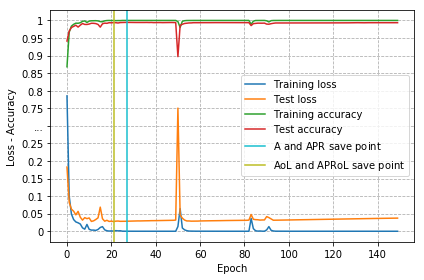

In [0]:
key = container_single['SADA_CNN-LSTM']
import pylab
fig = pylab.figure()
ax = fig.add_subplot(111)

ax.plot( np.array(list(key['hist']['loss'].items()))[:,1].astype(float), label='Training loss')
ax.plot( np.array(list(key['hist']['val_loss'].items()))[:,1].astype(float), label='Test loss')
ax.plot( np.array(list(key['hist']['acc'].items()))[:,1].astype(float)-0.4, label='Training accuracy')
ax.plot( np.array(list(key['hist']['val_acc'].items()))[:,1].astype(float)-0.4, label='Test accuracy')
ax.axvline( x=27, color=plt.cm.tab10(9), label='$\mathrm{A}$ and $\mathrm{APR}$ save point')
ax.axvline( x=21, color=plt.cm.tab10(8), label='$\mathrm{AoL}$ and $\mathrm{APRoL}$ save point')

ax.set_yticks(np.linspace(0,0.6,13))
ax.set_yticklabels(["0","0.05","0.1","0.15","0.2","0.25","...","0.75","0.8","0.85","0.9","0.95","1"]) 
ax.grid(linestyle='--')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss - Accuracy')
plt.tight_layout()

plot_folder = key['plots']['accuracy.png'][:-len('plot-accuracy.png')]
fname = os.path.join(plot_folder, 'plot-acc-loss')
plt.savefig(fname+'.png')
plt.savefig(fname+'.pdf', format='pdf')
fname = os.path.join(write_folder, 'plot-acc-loss')
plt.savefig(fname+'.png')
plt.savefig(fname+'.pdf', format='pdf')
plt.show()
plt.close()